![Alt Text](https://media3.giphy.com/media/nXg2lqVpal6KgSC8Zq/200.gif)



# Library import

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import gc
from tqdm.notebook import trange, tqdm

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss


from mpl_toolkits import mplot3d
from scipy.spatial import Delaunay

from IPython.display import Latex


# Data Loading

Using Dask we can Load in the entire data set. 

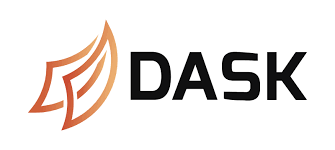

Copied Load in from [here](https://www.kaggle.com/code/donatoriccio/how-to-load-the-whole-dataset-in-2-lines-of-code?scriptVersionId=108551145&cellId=6)

In [ ]:
# import dask.dataframe as dd
# dtypes_dict = {
#     'game_num': 'int8', 'event_id': 'int8', 'event_time': 'float16',
#     'ball_pos_x': 'float16', 'ball_pos_y': 'float16', 'ball_pos_z': 'float16',
#     'ball_vel_x': 'float16', 'ball_vel_y': 'float16', 'ball_vel_z': 'float16',
#     'p0_pos_x': 'float16', 'p0_pos_y': 'float16', 'p0_pos_z': 'float16',
#     'p0_vel_x': 'float16', 'p0_vel_y': 'float16', 'p0_vel_z': 'float16',
#     'p0_boost': 'float16', 'p1_pos_x': 'float16', 'p1_pos_y': 'float16',
#     'p1_pos_z': 'float16', 'p1_vel_x': 'float16', 'p1_vel_y': 'float16',
#     'p1_vel_z': 'float16', 'p1_boost': 'float16', 'p2_pos_x': 'float16',
#     'p2_pos_y': 'float16', 'p2_pos_z': 'float16', 'p2_vel_x': 'float16',
#     'p2_vel_y': 'float16', 'p2_vel_z': 'float16', 'p2_boost': 'float16',
#     'p3_pos_x': 'float16', 'p3_pos_y': 'float16', 'p3_pos_z': 'float16',
#     'p3_vel_x': 'float16', 'p3_vel_y': 'float16', 'p3_vel_z': 'float16',
#     'p3_boost': 'float16', 'p4_pos_x': 'float16', 'p4_pos_y': 'float16',
#     'p4_pos_z': 'float16', 'p4_vel_x': 'float16', 'p4_vel_y': 'float16',
#     'p4_vel_z': 'float16', 'p4_boost': 'float16', 'p5_pos_x': 'float16',
#     'p5_pos_y': 'float16', 'p5_pos_z': 'float16', 'p5_vel_x': 'float16',
#     'p5_vel_y': 'float16', 'p5_vel_z': 'float16', 'p5_boost': 'float16',
#     'boost0_timer': 'float16', 'boost1_timer': 'float16', 'boost2_timer': 'float16',
#     'boost3_timer': 'float16', 'boost4_timer': 'float16', 'boost5_timer': 'float16',
#     'player_scoring_next': 'O', 'team_scoring_next': 'O', 'team_A_scoring_within_10sec': 'int8',
#     'team_B_scoring_within_10sec': 'int8'
# }


# df = dd.read_csv('../input/tabular-playground-series-oct-2022/train_*.csv', dtype = dtypes_dict)
# df = df.compute()
# df = df.iloc[:,:-2].head(1000000)
# df.shape[0]

In [ ]:
import os


In [ ]:
df_test = pd.read_feather("../input/fast-loading-high-compression-with-feather/feather_data/test_compressed.ftr")

In [ ]:
df = pd.read_feather("../input/fast-loading-high-compression-with-feather/feather_data/train_0_compressed.ftr")

# Delaunay Triangulation 

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/1f/Delaunay_circumcircles_centers.svg/1024px-Delaunay_circumcircles_centers.svg.png" alt="drawing" width="400"/>

## Definition: 
*In mathematics and computational geometry, a Delaunay triangulation (also known as a Delone triangulation) for a given set P of discrete points in a general position is a triangulation DT(P) such that no point in P is inside the circumcircle of any triangle in DT(P). Delaunay triangulations maximize the minimum of all the angles of the triangles in the triangulation; they tend to avoid sliver triangles. The triangulation is named after Boris Delaunay for his work on this topic from 1934.*


In [ ]:
def Delaunay_tri(x,y,z):
    '''function which perform Delaunay Triangulations 
    returns point indices and coordinates for triangles forming the triangulation '''
    points = np.vstack([x, y, z]).T
    tri = Delaunay(points)
    return points, tri

def Delaunay_tri_2D(x,y):
    points = np.vstack([x, y]).T
    tri = Delaunay(points)
    return points, tri


# Getting the Coordinates of Each Player and Adding the Static Coordinates of the Goals
The coordinates form the goal is taken from the discussion [here](https://www.kaggle.com/competitions/tabular-playground-series-oct-2022/discussion/356718)

## Defining Helper Functions

In [ ]:
def plot_tri(ax, points, tri):
    edges = collect_edges(tri)
    x = np.array([])
    y = np.array([])
    z = np.array([])
    for (i,j) in edges:
        x = np.append(x, [points[i, 0], points[j, 0], np.nan])      
        y = np.append(y, [points[i, 1], points[j, 1], np.nan])      
        z = np.append(z, [points[i, 2], points[j, 2], np.nan])
    ax.plot3D(x, y, z, color='g', lw='1')

    for i in range(len(points)): #plot each point + it's index as text above
        if i == 0:
            ax.scatter(points[i,0],points[i,1],points[i,2],color='r', s=120)
            ax.text(points[i,0],points[i,1],points[i,2],  '%s' % 'Ball', size=30, zorder=1)  
        elif i > 6:
            ax.scatter(points[i,0],points[i,1],points[i,2],color='yellow', s=120)
            ax.text(points[i,0],points[i,1],points[i,2],  '%s' % 'Goal', size=30, zorder=1)  
        else: 
            ax.scatter(points[i,0],points[i,1],points[i,2],color='b', s=120)
            ax.text(points[i,0],points[i,1],points[i,2],  '%s' % 'Player ' + (str(i)), size=30, zorder=1)
        

def collect_edges(tri):
    edges = set()

    def sorted_tuple(a,b):
        return (a,b) if a < b else (b,a)
    # Add edges of tetrahedron (sorted so we don't add an edge twice, even if it comes in reverse order).
    for (i0, i1, i2, i3) in tri.simplices:
        edges.add(sorted_tuple(i0,i1))
        edges.add(sorted_tuple(i0,i2))
        edges.add(sorted_tuple(i0,i3))
        edges.add(sorted_tuple(i1,i2))
        edges.add(sorted_tuple(i1,i3))
        edges.add(sorted_tuple(i2,i3))
    return edges

In [ ]:
# idx corresponding to the row of the dataframe, for now lets look at the first row
def get_coordinates(idx=0, cols=df.columns):
    x_cols = [col for col in cols if 'pos_x' in col]
    y_cols = [col for col in cols if 'pos_y' in col]
    z_cols = [col for col in cols if 'pos_z' in col]
    x = df[x_cols].loc[idx].to_list()
    y = df[y_cols].loc[idx].to_list()
    z = df[z_cols].loc[idx].to_list()
    goal_1 = np.array([0, -100, 0])
    goal_2 = np.array([0, 100, 0])
    x.extend([goal_1[0], goal_2[0]])
    y.extend([goal_1[1], goal_2[1]])
    z.extend([goal_1[2], goal_2[2]])
    return x,y,z

In [ ]:
x,y,z = get_coordinates(idx=10, cols=df.columns)
points, tri = Delaunay_tri(x,y,z)
fig = plt.figure(figsize=(20,17))
ax = plt.axes(projection='3d')
plot_tri(ax, points, tri)


# Some Example Metrics of the Delaunay Graph

In [ ]:
print('Number of Triangles {len(tri.simplices)} =', len(tri.simplices))
print('Hyperplane distance to goal 1 =', sum(tri.plane_distance(points[-1])))
print('Hyperplane distance to goal 2 =', sum(tri.plane_distance(points[-2])))
print('Hyperplane distance to the ball =', sum(tri.plane_distance(points[0])))

# 2D case

In [ ]:
import networkx as nx
from matplotlib.widgets import Slider

i = 100

x,y,_ = get_coordinates(idx=i)
point, tri = Delaunay_tri_2D(x,y)
G = nx.Graph()
for path in tri.simplices:
    nx.add_path(G, path)
    
nx.draw(G, with_labels=True, node_size=500, node_color='lightgreen')

In [ ]:
# Number of noder = Order of the graph
G.order()

### Density of the Graph

In [ ]:
# Density of the graph = Graph density represents the ratio between the edges present in a graph and the maximum number of edges that the graph can contain
from networkx.classes.function import density
density(G)

In [ ]:
from networkx.classes.function import degree
degree(G, nbunch=None, weight=None)

### Degree Histogram

In [ ]:
from networkx.classes.function import degree_histogram
degree_histogram(G)

### Neigbors of the nodes

In [ ]:
from networkx.classes.function import neighbors
for node in G.nodes():
    print(node, list(G.neighbors(node)))


## Adjacency Matrix of The Undirected/ Unweighted Graph

In [ ]:
# Get the adjacnency Matrix with sorted nodes and cast to numpy array
A = nx.to_numpy_array(G, nodelist=sorted(G.nodes()))
A

Another Matrix Representation which is used often in CNN is the Laplacian Matrix


# Laplacian Matrix

The graph Laplacian is the matrix $\large L = D - A$, <br>where A is the adjacency matrix and D is the diagonal matrix of node degrees.<br>
In most applications it is further sensible to normalize it with $\large N = D^{1/2} L D^{-1/2}$

In [ ]:
L = nx.normalized_laplacian_matrix(G,nodelist=sorted(G.nodes()))
L = np.array(L.todense())
L

In [ ]:
from sklearn.manifold import spectral_embedding
y = spectral_embedding(adjacency=A, 
                                n_components=1, 
                                norm_laplacian=False, 
                                drop_first=True,
                                eigen_solver='lobpcg')



In [ ]:
y

This Matrix representing a specific graph of player and ball positions can now be used to train our model.

# Simple Approach: Flattening the Laplacian Matrix + ONLY 2D Positions of the players

In [ ]:
df = df.dropna()
y_b = df['team_B_scoring_within_10sec']
y_a = df['team_A_scoring_within_10sec']
df_train = df.copy()

In [ ]:
df_test

In [ ]:
print(df_train.columns)
# Defining all columns which we willd drop for now!
to_drop = ['game_num','event_id', 'event_time', 'player_scoring_next', 'team_scoring_next', 'team_B_scoring_within_10sec','team_A_scoring_within_10sec']
z_list =  [i for i in df_train.columns if '_z' in i]
vels = [i for i in df_train.columns if 'vel' in i]
boost  = [i for i in df_train.columns if 'boost' in i]
all_drop = to_drop+vels+boost+z_list
df_train = df_train.drop(all_drop, axis = 1)


I Have already created graphs for train_sample_a and test data. Else the code below will create graphs from the positions

In [ ]:
# import networkx as nx

# x_cols = [col for col in df_train.columns if 'pos_x' in col]
# y_cols = [col for col in df_train.columns if 'pos_y' in col]
# goal_1 = np.array([0, -100, 0])
# goal_2 = np.array([0, 100, 0])

# L_train_list = []
# for i, rows in tqdm(df_train.iterrows()):
#     if int(i) % 10000 == 0:
#         print(i)
#     x = rows[x_cols].to_list()
#     y = rows[y_cols].to_list()
#     x.extend([goal_1[0], goal_2[0]])
#     y.extend([goal_1[1], goal_2[1]])
#     points, tri = Delaunay_tri_2D(x,y)
#     G = nx.Graph()
#     for path in tri.simplices:
#         nx.add_path(G, path)
#     A = nx.to_numpy_array(G, nodelist=sorted(G.nodes()))
#     y = spectral_embedding(adjacency=A, 
#                                 n_components=1, 
#                                 norm_laplacian=False, 
#                                 drop_first=True,
#                                 eigen_solver='lobpcg').flatten()
#     L_train_list.append(pd.DataFrame((y.reshape(-1, len(y))), index=[str(i)]))
# L_train = pd.concat([i.iloc[:,1:] for i in L_train_list])   
# L_train['y_a'] = list(y_a)
# L_train['y_b'] = list(y_b)

In [ ]:
# ###### CONVERTING THE TEST SET TO A GRAPH DATA ################
# X_test = pd.read_csv('../input/tabular-playground-series-oct-2022/test.csv')
# df_test = X_test.drop('id', axis = 1).fillna(0)
# x_cols = [col for col in df_test.columns if 'pos_x' in col]
# y_cols = [col for col in df_test.columns if 'pos_y' in col]
# goal_1 = np.array([0, -100, 0])
# goal_2 = np.array([0, 100, 0])

# L_test_list = []
# for i, rows in tqdm(df_test.iterrows()):
#     if int(i) % 5000 == 0:
#         print(i)
#     x = rows[x_cols].to_list()
#     y = rows[y_cols].to_list()
#     x.extend([goal_1[0], goal_2[0]])
#     y.extend([goal_1[1], goal_2[1]])
#     points, tri = Delaunay_tri_2D(x,y)
#     G = nx.Graph()
#     for path in tri.simplices:
#         nx.add_path(G, path)
#     A = nx.to_numpy_array(G, nodelist=sorted(G.nodes()))
#     y = spectral_embedding(adjacency=A, 
#                                 n_components=1, 
#                                 norm_laplacian=False, 
#                                 drop_first=True,
#                                 eigen_solver='lobpcg').flatten()
#     L_test_list.append(pd.DataFrame((y.reshape(-1, len(y))), index=[str(i)]))
# L_test = pd.concat([i.iloc[:,1:] for i in L_test_list])

In [ ]:
# L_test.columns = L_test.columns.astype(str)
# L_test.reset_index().to_feather('spectral_test_data.ftr')
# L_test.reset_index().to_csv('spectral_test_data.csv')

# L_train.columns = L_train.columns.astype(str)
# L_train.reset_index().to_csv('spectral_train_data_a.csv')
# L_train.reset_index().to_feather('spectral_train_data_b.ftr')

In [ ]:
y_b

because of the process still being very slow I preprocessed the test data into a graph.

In [ ]:
L_test = pd.read_feather('../input/spectral-data-rl/spectral_test_data.ftr')
L_train = pd.read_feather('../input/spectral-data-rl/spectral_train_data_a.ftr')

In [ ]:
L_train.head(3), y_a.head(3), y_a.head(3)

# Some additional feature engineering

As for now we have only considered the x and y positions of the players and the ball. Lets include some other features.
Lets look at the veloctiy features of the dataframe

In [ ]:
df[vels].head()

In [ ]:
df_train

In [ ]:
def new_feat(df=df):
    df_vels = df[vels]
    drop_timer = [i for i in df[boost].columns if 'timer' in i]
    boost_df = df[boost].drop(columns=drop_timer).reset_index()
    z_df = df[z_list].reset_index()
    v_dicts = {'ball_v' : df_vels.iloc[:, 0:3].values,
               'p_0_v' : df_vels.iloc[:,3:6].values,
               'p_1_v' : df_vels.iloc[:,6:9].values,
               'p_2_v' : df_vels.iloc[:,9:12].values,
               'p_3_v' : df_vels.iloc[:,12:15].values,
               'p_4_v' : df_vels.iloc[:,15:18].values,
               'p_5_v' : df_vels.iloc[:,18:21].values}
    #     v_abs = pd.DataFrame({key: np.linalg.norm(value, axis=1) for key, value in v_dicts.items()})
    # Absolute values of velocity
    v_abs_all = pd.DataFrame({'ball_vel' : np.linalg.norm(v_dicts['ball_v'], axis=1),
                              'player_vel' : sum(np.linalg.norm(value, axis=1) for _, value in v_dicts.items())})
    # Correlation between each player and the ball
    v_corr_all = pd.DataFrame({'team_ball_corr': sum(np.einsum('ij,ij->i', v_dicts['ball_v'], value) for _, value in v_dicts.items())})
    
    df_new_feat = pd.concat([v_corr_all, v_abs_all, boost_df], axis=1)
    df_new_feat_norm = df_new_feat/df_new_feat.max()
    return df_new_feat_norm

# Orientation correlation
An interesting metric could be the correlation between the orientation of the ball velocity and the players velocity. As Rocket League is a team sport its reasonable to assume that the orientations of each player would need to point in the same direction? 

# Distributions of the Velocity Correlations and Absolute Velocities

In [ ]:
df_feats = new_feat(df=df)
L_train_ = L_train.drop(columns=['ball_vel', 'team_ball_corr', 'player_vel'])
L_train_new = pd.concat([L_train_, df_feats], axis=1)
L_train_new = L_train_new.drop(columns=['index'])
L_train_new.shape

In [ ]:
df_test_feats = new_feat(df=df_test)
L_test_ = L_test.drop(columns=['ball_vel', 'team_ball_corr', 'player_vel'])
L_test_new = pd.concat([L_test_, df_test_feats], axis=1)
L_test_new = L_test_new.drop(columns=['index'])
L_test_new.shape

In [ ]:
sns.histplot(data=L_train_new.iloc[:,:9], kde=True)

In [ ]:
gc.collect()

modelA = LGBMClassifier(objective='binary',
                      metric='logloss',
                      importance_type='gain',
                      random_state=42,
                      zero_as_missing=True,
                      learning_rate=0.1,
                      max_depth=10,
                      min_child_samples=340,
                      min_child_weight=1e-05,
                      n_estimators=100,
                      num_leaves=130,
                      reg_alpha=50,
                      reg_lambda=50)

modelA.fit(L_train_new, y_a)
y_a_pred = modelA.predict_proba(L_test_new)
print('Model A trained')

# del modelA 
# gc.collect()

modelB = LGBMClassifier(objective='binary',
                      metric='logloss',
                      importance_type='gain',
                      random_state=42,
                      zero_as_missing=True,
                      learning_rate=0.1,
                      max_depth=10,
                      min_child_samples=340,
                      min_child_weight=1e-05,
                      n_estimators=100,
                      num_leaves=130,
                      reg_alpha=50,
                      reg_lambda=50)

modelB.fit(L_train_new, y_b)
print('Model B trained')
y_b_pred = modelB.predict_proba(L_test_new)

# del modelB 
# gc.collect()

submission = pd.read_csv('../input/tabular-playground-series-oct-2022/sample_submission.csv', usecols = ['id'])
submission['team_A_scoring_within_10sec'] = y_a_pred[:,1]
submission['team_B_scoring_within_10sec'] = y_b_pred[:,1]
submission.to_csv('submission.csv', index = False)

In [ ]:
y_pred_A = modelA.predict(L_train_new)
y_pred_B = modelB.predict(L_train_new)
# view accuracy
from sklearn.metrics import accuracy_score

accuracy_A = accuracy_score(y_pred_A, y_a)
accuracy_B = accuracy_score(y_pred_B, y_b)
print(f'LightGBM Model accuracy scores: {accuracy_A, accuracy_B}')

# Summary

With this super simplified method of only using the x and y positions of each player to construct a graph + completely ignoring all other parameters + only using train_a samples this method achieves a score of $\large 0.22114$. Now we need to include the other parameters and more train sample to increase the score, but the approach seems promising!


--------------------------------------------------------------------------------------------------------------------------------------------------------

# *FUTURE WORK*

# Using the Graphs as Inputs for a GNN 

### A GNN is is a neural network that can directly be applied to graphs on:
* node level 
* edge level
* **graph level**

we are interested in a Graph Classification on graph level: <br>
### **Given a graph of player and ball positions will the team score within 10s?**

# Node Embeddings in GNN 
## Principle 
* Nodes have neighbors and connections 
* Neighors of a node and connections to neighbors define the concept of the node <br>

## Node Embeddings
* Every node represents its concept as a state ($x$)
* The node state ($x$) produces the decision about its concepts an an output ($o$)
* The final state ($x_n$) of the node is called Node Embedding

## TO BE CONTINUED 